In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

# Boostings

Данные с которыми вы будете работать представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные выплаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых клиент был связан с компанией


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [ ]:
data = pd.read_csv('vehicle_insurance.csv')

data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,24,1,37.0,1,< 1 Year,No,21243.0,152.0,21,0
9996,Male,28,1,35.0,1,< 1 Year,No,23589.0,160.0,173,0
9997,Female,27,1,15.0,0,< 1 Year,Yes,33340.0,152.0,207,0
9998,Female,28,1,14.0,1,< 1 Year,No,25426.0,152.0,247,0


**Задание 0.** Проведите небольшой EDA. Посмотрите на распределения некоторых колонок, на матрицу корреляций. Также проверьте баланс классов и посмотрите на распределение возраста транспортного средства в зависимости от response. \

Закодируйте признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object`колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

In [ ]:
for col in data.select_dtypes("object").columns:
    one_hot = pd.get_dummies(data[col], prefix=col, drop_first=True)
    data = data.drop(columns=[col])
    data = pd.concat((data, one_hot), axis=1)

<Axes: >

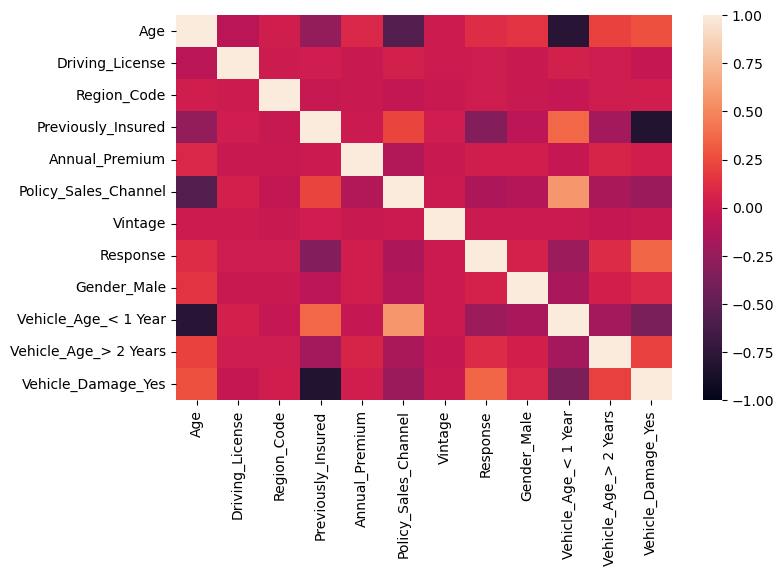

In [ ]:
corr = data.corr()

sns.heatmap(corr, vmin=(-1))

**Задание 1.** Обучите градиентный бустинг из sklearn на данных и замерьте accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установите `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразите ROC-кривую и посчитайте AUC, оцените качество классификации. (2б)

P.S. для всех прочих моделей в этом домашнем задании тоже фиксируйте `random_state = 1`. Как думаете, что может быть случайного в процедуре обучения градиентного бустинга?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

boost = GradientBoostingClassifier(learning_rate=1, random_state=1, n_estimators=100)

boost.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, random_state=1)

In [ ]:
print(classification_report(y_test, boost.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1770
           1       0.31      0.24      0.27       230

    accuracy                           0.85      2000
   macro avg       0.61      0.59      0.59      2000
weighted avg       0.84      0.85      0.84      2000



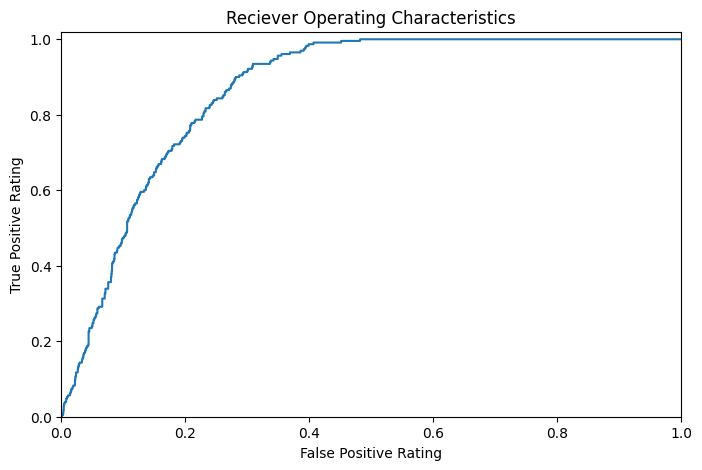

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, boost.predict_proba(X_test)[:,1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve: {roc_auc}")

plt.title("Reciever Operating Characteristics")
plt.xlim([0.0, 1.0])
plt.xlabel("False Positive Rating")
plt.ylim([0.0, 1.02])
plt.ylabel("True Positive Rating")
plt.legend()

plt.show()

**Задание 2.** Переберите параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считайте f1-score на тестовой выборке и сохраняйте результат в матрицу. Для какого алгоритма качество окажется максимальным?

Постройте кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразите heatmap полученной матрицы. Сделайте вывод, как количество шагов влияет на качество совместно с различной скоростью обучения? (2б)

P.S. для подсчета f1-score передайте в функцию параметр `average='weighted'`, чтобы учитывался еще и баланс классов (вспомните микро/макро-усреднения).

In [ ]:
### Задаем сетку параметров

n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

In [ ]:
result_dict = {}

for learning_rate in learning_rate_list:
    result_dict[learning_rate] = {}
    for n_estimators in n_estimators_list:
        boost = GradientBoostingClassifier(random_state=1, n_estimators=n_estimators, max_depth=5, learning_rate=learning_rate)

        boost.fit(X_train, y_train)
        result_dict[learning_rate][n_estimators] = f1_score(y_test, boost.predict(X_test), average="weighted")

results_df = pd.DataFrame(result_dict)

<Axes: >

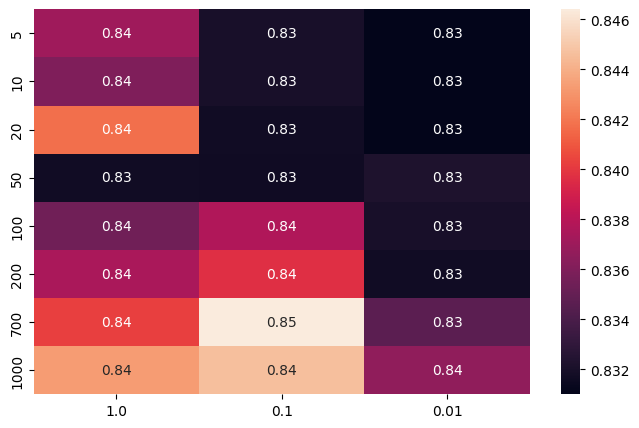

In [ ]:
sns.heatmap(results_df, annot=True)

In [ ]:
results_df.max().max()

0.8464029319213884

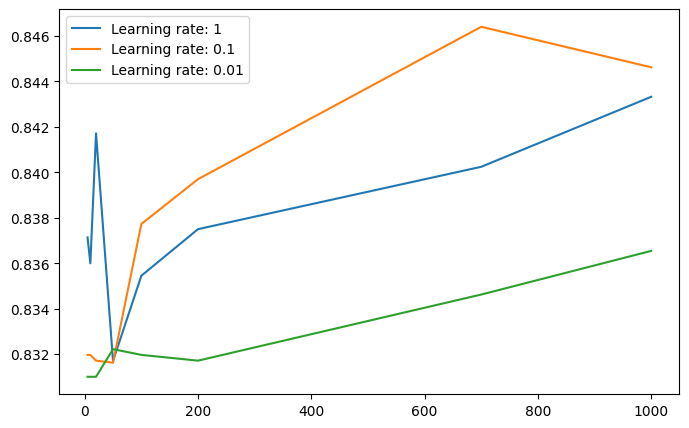

In [ ]:
for learning_rate in result_dict:
    dct = result_dict[learning_rate]
    plt.plot(dct.keys(), dct.values(), label=f"Learning rate: {learning_rate}")

plt.legend()
plt.show()

**Задание 3.** Вам потребуется обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели.
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели перебирайте значения `n_estimators`, как в предыдущем задании. Отрисуйте графики зависимости f1-score от количества шагов, используя `average='weighted'` для учёта баланса классов.

Если в качестве базовой модели брать неглубокие деревья, то какая модель лучше запоминает обучающую выборку: случайный лес или градиентный бустинг? Какая из них лучше предсказывает на тестовой выборке? Как изменятся ответы, если базовая модель - это глубокое решающее дерево?

Подвержен ли переобучению случайный лес и градиентный бустинг? Как это отражается на графиках? (4б)

In [ ]:
def test_n_estimators(model, n_estimators_list: list, X_train, X_test, y_train, y_test):
        f1_scores_train = {}
        f1_scores_test = {}
        for n_estimators in n_estimators_list:
            model.n_estimators = n_estimators

            model.fit(X_train, y_train)

            f1_train = f1_score(y_train, model.predict(X_train))
            f1_test = f1_score(y_test, model.predict(X_test))

            f1_scores_test[n_estimators] = f1_test
            f1_scores_train[n_estimators] = f1_train

        return f1_scores_train, f1_scores_test

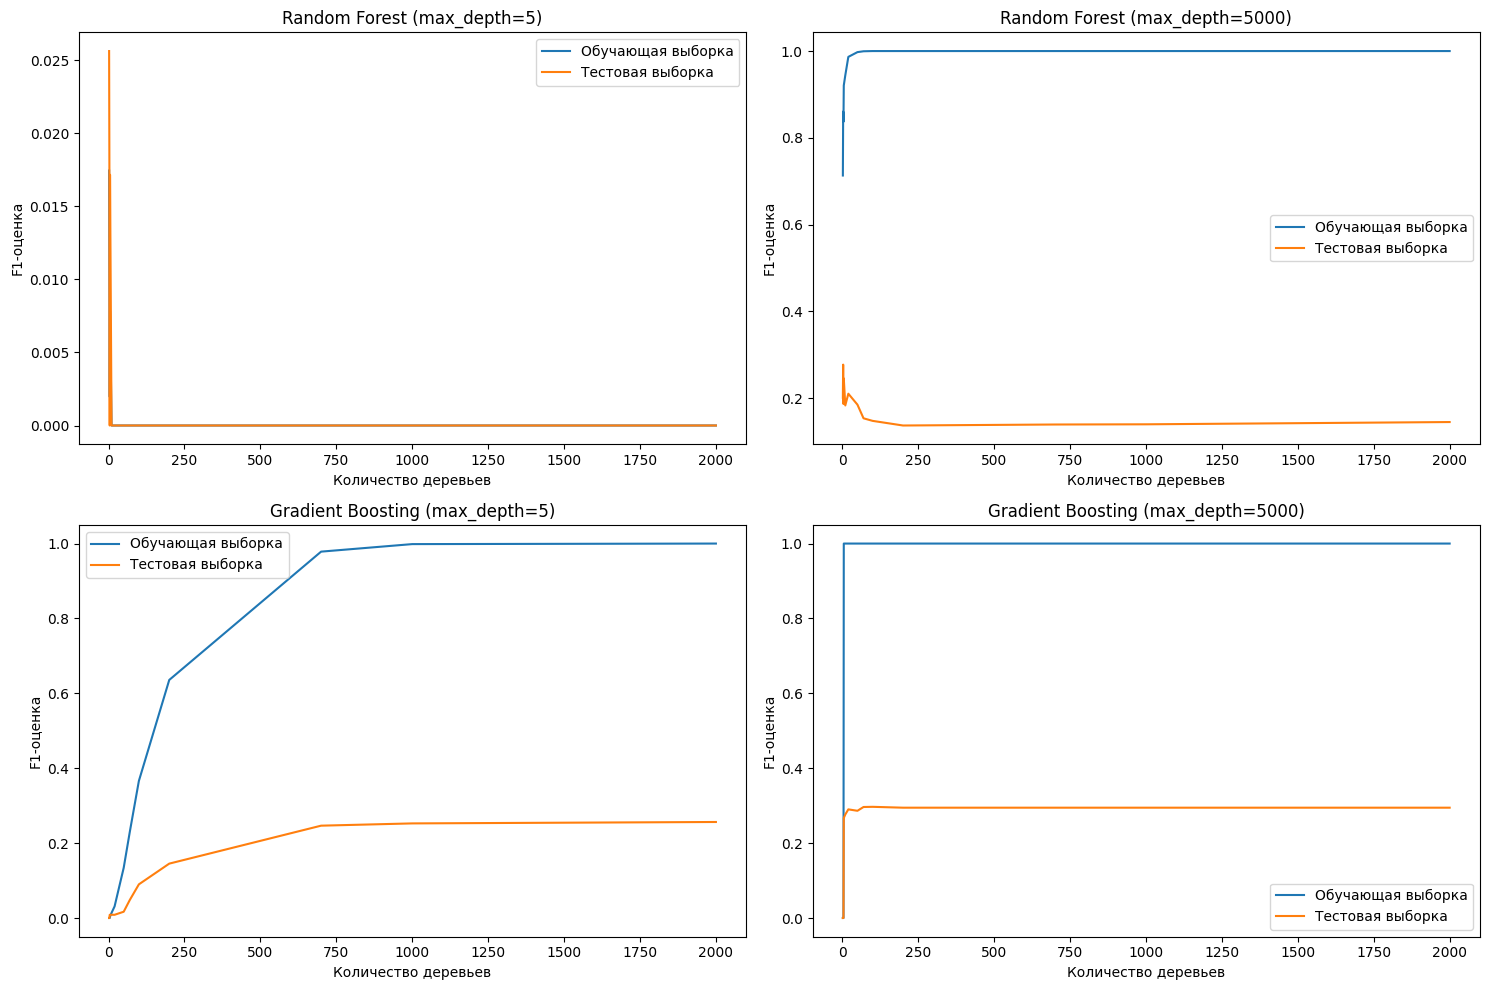

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]

models = [
    RandomForestClassifier(max_depth=5, random_state=1),
    RandomForestClassifier(max_depth=5000, random_state=1),
    GradientBoostingClassifier(max_depth=5, random_state=1),
    GradientBoostingClassifier(max_depth=5000, random_state=1)
]

model_names = [
    "Random Forest (max_depth=5)",
    "Random Forest (max_depth=5000)",
    "Gradient Boosting (max_depth=5)",
    "Gradient Boosting (max_depth=5000)"
]

plt.figure(figsize=(15, 10))

for i, (model, model_name) in enumerate(zip(models, model_names)):
    f1_scores_train, f1_scores_test = test_n_estimators(model, n_estimators_list, X_train, X_test, y_train, y_test)

    plt.subplot(2, 2, i + 1)
    plt.plot(f1_scores_train.keys(), f1_scores_train.values(), label="Обучающая выборка")
    plt.plot(f1_scores_test.keys(), f1_scores_test.values(), label="Тестовая выборка")
    plt.xlabel("Количество деревьев")
    plt.ylabel("F1-оценка")
    plt.title(model_name)
    plt.legend()

plt.tight_layout()
plt.show()


**Задание 4.** Установите библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют.
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage.

Почитать подробнее можно здесь: [Transforming categorical features](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)

Обучите CatBoostClassifier с дефолтными параметрами. Используйте датасет до  (разбейте на train/test по старой логике с тем же random state'ом). Категориальные колонки передайте в параметр `cat_features` метода `fit`. Catboost сам с ними разберется.

Сравните качество с моделью из предыдущего задания. Стало ли лучше?

Сравните feature importances в модели из задания 2 и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. \
Какие признаки стали более важными с новым методом кодирования? (4б)

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

# Перезагружаем данные
cat_data = pd.read_csv('vehicle_insurance.csv')

# Определяем признаки и целевую переменную
X = cat_data.drop('Response', axis=1)
y = cat_data['Response']

#

# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [ ]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(random_state=1, cat_features=['Gender', 'Vehicle_Age', 'Vehicle_Damage'])
catboost.fit(X_train, y_train)

y_pred = catboost.predict(X_test)

# Подсчитываем F1-оценку
print(f"F1-оценка: {f1_score(y_test, y_pred, average='weighted'):.3f}")

Learning rate set to 0.025035
0:	learn: 0.6585225	total: 3.28ms	remaining: 3.28s
1:	learn: 0.6268982	total: 5.74ms	remaining: 2.87s
2:	learn: 0.5928588	total: 8.25ms	remaining: 2.74s
3:	learn: 0.5650766	total: 10.6ms	remaining: 2.64s
4:	learn: 0.5422486	total: 13.4ms	remaining: 2.66s
5:	learn: 0.5180757	total: 15.8ms	remaining: 2.61s
6:	learn: 0.4967701	total: 18.4ms	remaining: 2.61s
7:	learn: 0.4783631	total: 20.8ms	remaining: 2.58s
8:	learn: 0.4615549	total: 23.3ms	remaining: 2.56s
9:	learn: 0.4527304	total: 26ms	remaining: 2.57s
10:	learn: 0.4445958	total: 28.8ms	remaining: 2.59s
11:	learn: 0.4300633	total: 31.2ms	remaining: 2.57s
12:	learn: 0.4153701	total: 33.9ms	remaining: 2.57s
13:	learn: 0.4046506	total: 36.5ms	remaining: 2.57s
14:	learn: 0.3953227	total: 39.1ms	remaining: 2.57s
15:	learn: 0.3908375	total: 41.7ms	remaining: 2.57s
16:	learn: 0.3866243	total: 44.2ms	remaining: 2.56s
17:	learn: 0.3780907	total: 46.6ms	remaining: 2.54s
18:	learn: 0.3711807	total: 49.3ms	remaining: 

In [ ]:
import numpy as np

train_preds = catboost.predict(X_train)
test_preds = catboost.predict(X_test)

train_error = np.mean((train_preds - y_train.values.ravel())**2)
test_error = np.mean((test_preds - y_test.values.ravel())**2)

print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.094
Качество на тесте: 0.118


In [ ]:
# Выберите три признака, которые в алгоритме catboost обладают наибольшей важностью
print(catboost.feature_importances_)

# Выпишем названия топ 3 признаков
print(catboost.feature_names_)


[ 3.23807524 11.46580527  0.03653458  8.58680315 28.99594912  4.05248126
 18.24543566  9.71740098  6.67470085  8.98681388]
['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']


**Задание 5.** Установите библиотеку `lightgbm`. На сегодняшний день это наиболее быстрый метод градиентного бустинга, при этом расходующий небольшое количество оперативной памяти. Достигает он этого за счет построения деревьев вглубь по листьям (leaf-wise), а не по уровням (level-wise), как другие методы, например XGBoost.
Более понятно это на картинке:

![%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png](attachment:%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png)

![%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5-2.png](attachment:%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5-2.png)

В то время, как XGBoost за раз разделяет вершины на целом уровне той же глубины, LightGBM разделяет одну вершину за раз. Отсюда прирост в скорости.

Обучите `LGBMClassifier` на изначальных(закодированных) данных и добейтесь максимального качества на тестовой выборке, перебрав параметры глубины деревьев, количества шагов, скорости обучения и т.д.

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [100, 500, 1000, 2000],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

lgbm = LGBMClassifier(random_state=1,verbosity=-1)

# Подбор наилучших параметров
grid_search = GridSearchCV(lgbm, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров и метрики качества на тестовой выборке
print("Best parameters: ", grid_search.best_params_)
print("Test accuracy: ", grid_search.score(X_test, y_test))




Best parameters:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}
Test accuracy:  0.885


In [ ]:
from sklearn.metrics import precision_score

# Предсказание на тестовой выборке
y_pred = grid_search.predict(X_test)

# Вычисление precision для класса 0
precision = precision_score(y_test, y_pred, pos_label=0)  # pos_label=0 указывает на интересующий нас класс

# Вывод значения precision для класса 0, округлённое до сотых
print("Precision for class 0: {:.2f}".format(precision))

Precision for class 0: 0.89
